In [36]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

from scipy.integrate import odeint

# First go is set-up like this

$$\frac{dI_k}{dt} = \beta k \theta (p_k - I_k - V_k) + f \beta k \theta V_k - (1+f)I_k$$

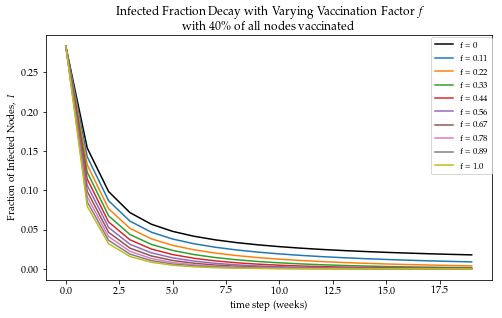

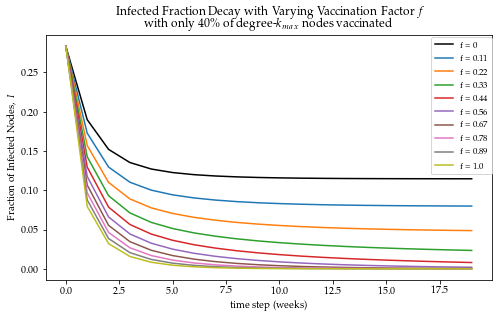

In [165]:
def p_k(p,k):
    return p*(1-p)**(k)

def I_k_dt(i,t,v,f):
    '''
    pass in a row of Ik
                 and Vk
    '''
    beta = 0.3 #(1/week)
    alpha = 1 #(1/week)
    p = 1/4
    Pk = {k:p_k(p,k) for k in k_dist}
    avgk = np.sum([k*Pk[k] for k in Pk])
    i2 = np.zeros(10)
    
    for k in Pk:
        theta = np.sum([(k*i[k])/(avgk) for k in k_dist])
        if f==0:
            i2[k] = beta*k*(Pk[k]-i[k]-v[k])*theta - (1)*i[k]
        else:
            i2[k] = beta*k*(Pk[k]-i[k]-v[k])*theta + beta*k*f*v[k]*theta - (1+f)*i[k]

    return i2

time = 20
init_Inf = 0.3
figdim = (8,4.5)
k_dist = [0,1,2,3,4,5,6,7,8,9]
beta = 0.3 #(1/week)
alpha = 1 #(1/week)
p = 1/4
Pk = {k:p_k(p,k) for k in k_dist}
avgk = np.sum([k*Pk[k] for k in Pk])
i2 = np.zeros(10)
I = np.zeros((time,10))
# the initial fraction of infected nodes
I[0] = [init_Inf*Pk[k] for k in k_dist]
V = np.zeros(10)
# the initial fraction of vaccinated nodes
V = [.40*(Pk[k]-I[0][k]) for k in k_dist]

fs = np.linspace(0,1,10)
T = np.arange(0,time)
plt.figure(figsize=figdim)
f=0
sol = odeint(I_k_dt, I[0], T, args=(V,f))
plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)),color='k')
for f in fs[1:]:
    sol = odeint(I_k_dt, I[0], T, args=(V,f))
    plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)))
plt.legend(bbox_to_anchor=(1.01,1.01),fontsize=9)
plt.title(r'Infected Fraction Decay with Varying Vaccination Factor $f$'+'\n with 40\% of all nodes vaccinated')
plt.xlabel('time step (weeks)')
plt.ylabel(r'Fraction of Infected Nodes, $I$')
plt.savefig('figs/changeinI_Vallnodes.pdf',bbox_inches='tight')
plt.show()

# Now with only 40% of the kmax nodes vaccinated:
V = np.zeros(10)
V[-1] = 0.4*(Pk[9]-I[0][9])

plt.figure(figsize=figdim)
f=0
sol = odeint(I_k_dt, I[0], T, args=(V,f))
plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)),color='k')
for f in fs[1:]:
    sol = odeint(I_k_dt, I[0], T, args=(V,f))
    plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)))
plt.legend(bbox_to_anchor=(1.01,1.01),fontsize=9)
plt.title(r'Infected Fraction Decay with Varying Vaccination Factor $f$'+'\n with only 40\%'+r' of degree-$k_{max}$ nodes vaccinated')
plt.xlabel('time step (weeks)')
plt.ylabel(r'Fraction of Infected Nodes, $I$')
plt.savefig('figs/changeinI_Vkmaxnodes.pdf',bbox_inches='tight')
plt.show()

# Here I'm trying to break the nodes into two groups:
$V$, vaccinated and $S$, (not vaccinated)
both of which can go between infected and not-infected states

So the estimation of change in infected nodes is calculates for those in both $V$ and $S$:

$$\frac{dI_kV}{dt} = \beta k f (p_kv - I_kV)\theta - \frac{1}{f}I_kV$$

$$\frac{dI_kS}{dt} = \beta k (p_ks - I_kS)\theta - I_kS$$

Something is wrong though, since a perfect vaccine should be $f=0$, while a useless vaccine would be $f=1$ since the $V$ node equations would just become the same as the $S$ ones.

This isn't what the plots are showing though :( in either the above or below versions :(


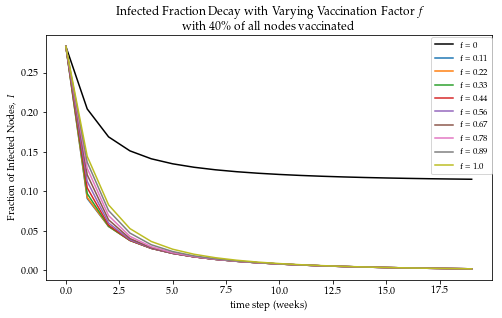

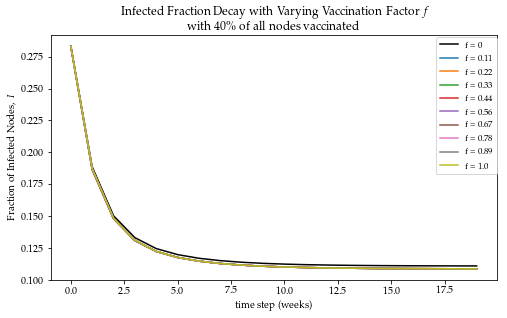

In [167]:
def p_k(p,k):
        return p*(1-p)**(k)
    
class SIS_config:
    def __init__(self,time=20,i_prop=0.3,v_prop=0.4,kmax_only=False):
        self.beta = 0.3 #(1/week)
        self.alpha = 1  #(1/week)
        k_dist = [0,1,2,3,4,5,6,7,8,9]
        
        p = 1/4
        if kmax_only:
            self.Pvk = {k:0 for k in k_dist[:-1]}
            self.Pvk[k_dist[-1]] = p_k(p,k_dist[-1])*v_prop
            self.Psk = {k:p_k(p,k) for k in k_dist[:-1]}
            self.Psk[k_dist[-1]] = p_k(p,k_dist[-1])*(1-v_prop)
            
        else:
            self.Pvk = {k:p_k(p,k)*v_prop for k in k_dist}
            self.Psk = {k:p_k(p,k)*(1-v_prop) for k in k_dist}
            
        self.avgk = np.sum([k*(self.Pvk[k]+self.Psk[k]) for k in k_dist])
        self.Iv0 = [self.Pvk[k]*(i_prop) for k in k_dist]
        self.Is0 = [self.Psk[k]*(i_prop) for k in k_dist]

    def IV_dt(self,Iv,t,f):
        '''
        pass in a row of I_v
                     and V
        '''
        Iv2 = np.zeros(10)

        for k in Pk:
            theta = np.sum([(k*Iv[k])/(self.avgk) for k in k_dist])
            if f==0:
                Iv2[k] = self.beta*k*f*(self.Pvk[k]-Iv[k])*theta - (0)*Iv[k]
            else:
                Iv2[k] = self.beta*k*f*(self.Pvk[k]-Iv[k])*theta - (1/f)*Iv[k]

        return Iv2

    def IS_dt(self,Is,t):
        '''
        pass in a row of I_s
                     and S
        '''
        Is2 = np.zeros(10)

        for k in Pk:
            theta = np.sum([(k*Is[k])/(self.avgk) for k in k_dist])
            Is2[k] = self.beta*k*(self.Psk[k]-Is[k])*theta - Is[k]

        return Is2
    
    def approx_I_next(self,f):
        T = np.arange(0,time)
        sol_v = odeint(self.IV_dt, self.Iv0, T, args=(f,))
        sol_s = odeint(self.IS_dt, self.Is0, T)
        
        sol = np.zeros((time,10))
        for t in range(len(sol)):
            sol[t] = [sol_v[t][i]+sol_s[t][i] for i in range(len(sol_v[t]))]
        
        return sol


time = 20
figdim = (8,4.5)
SIS_model = SIS_config(time=time,i_prop=0.3,v_prop=0.4,kmax_only=False)

fs = np.linspace(0,1,10)
T = np.arange(0,time)
plt.figure(figsize=figdim)
f=0
sol = SIS_model.approx_I_next(f)
plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)),color='k')
for f in fs[1:]:
    sol = SIS_model.approx_I_next(f)
    plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)))
plt.legend(bbox_to_anchor=(1.01,1.01),fontsize=9)
plt.title(r'Infected Fraction Decay with Varying Vaccination Factor $f$'+'\n with 40\% of all nodes vaccinated')
plt.xlabel('time step (weeks)')
plt.ylabel(r'Fraction of Infected Nodes, $I$')
plt.savefig('figs/changeinI_Vallnodes.pdf',bbox_inches='tight')
plt.show()

# Now with only 40% of the kmax nodes vaccinated:
SIS_model = SIS_config(time=time,i_prop=0.3,v_prop=0.4,kmax_only=True)

plt.figure(figsize=figdim)
f=0
sol = SIS_model.approx_I_next(f)
plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)),color='k')
for f in fs[1:]:
    sol = SIS_model.approx_I_next(f)
    plt.plot(T,np.sum(sol,axis=1),label='f = {}'.format(round(f,2)))
plt.legend(bbox_to_anchor=(1.01,1.01),fontsize=9)
plt.title(r'Infected Fraction Decay with Varying Vaccination Factor $f$'+'\n with 40\% of all nodes vaccinated')
plt.xlabel('time step (weeks)')
plt.ylabel(r'Fraction of Infected Nodes, $I$')
plt.savefig('figs/changeinI_Vallnodes.pdf',bbox_inches='tight')
plt.show()